In [2]:
import boto
import matplotlib.pyplot as plt
import re
import datetime
import requests
AWS_ACCESS_KEY_ID = ''
AWS_SECRET_KEY = ''
bucket_name = '251mids'
s3_connection = boto.connect_s3(AWS_ACCESS_KEY_ID, AWS_SECRET_KEY)
bucket = s3_connection.get_bucket(bucket_name)

In [12]:
total_keys = {}
for keys in bucket.list():
    if re.match(r".*tweet.*part.*", keys.name):
        ts = int(re.findall(r'[0-9]{8,}', keys.name)[0])/1000
        ts = datetime.datetime.fromtimestamp(ts)
        hour = datetime.datetime.strptime(datetime.datetime.strftime(ts, "%H:00:00 %Y-%m-%d"), "%H:00:00 %Y-%m-%d")
        contents = keys.get_contents_as_string()
        contents = contents.strip().split('\n')
        contents = [(re.sub(r'[^0-9a-zA-Z\.\:]', ' ', line.replace('\n', '. ').replace('"', "'")).split('\t')[0], int(line.split('\t')[-1])) for line in contents if len(line) != 0]
        #print len(contents), hour, len(total_keys)
        #print len(total_keys.get(hour))
        total_keys[hour] = total_keys.get(hour, []) + contents
print '\n'.join(total_keys.keys())

TypeError: sequence item 0: expected string, datetime.datetime found

In [25]:
url = 'http://www.sentiment140.com/api/bulkClassify?query=trump'
avg_sentiments = []
for key in total_keys.keys():
    sents = {}
    print key, len(total_keys[key])
    counts = total_keys[key]
    tweets = [u[0] for u in counts]
    c = len(tweets)/8000 + 1
    _id = 0
    for i in range(c):
        data_string = '\n'.join(tweets[i * 8000: (i+1)* 8000])
        r = requests.post(url, data_string)
        u = [(v.split('","')[1][:-1], eval(v.split(',')[0])) for v in r.text.strip().split('\n')]
        print len(u)
        for string, sentiment in u:
            if sentiment == '0':
                s = -1.0
            elif sentiment == '2':
                s = 0.0
            elif sentiment == '4':
                s = 1.0
            else:
                raise ValueError
            sents[counts[_id][0]] = (counts[_id][1], s)
            _id += 1
    print
    sent2 = sents.items()
    s = sum([u[1][0] * u[1][1] for u in sent2])
    to = sum([u[1][0] for u in sent2])
    avg_sentiments.append((key, s / to))

2016-04-14 19:00:00 5818
5818

2016-04-14 20:00:00 6155
6155

2016-04-14 05:00:00 2700
2700

2016-04-13 20:00:00 14238
8000
6238

2016-04-14 00:00:00 8358
8000
358

2016-04-13 23:00:00 10598
8000
2598

2016-04-15 00:00:00 5625
5625

2016-04-14 11:00:00 7107
7107

2016-04-14 06:00:00 3446
3446

2016-04-14 17:00:00 5420
5420

2016-04-14 03:00:00 2146
2146

2016-04-14 04:00:00 2350
2350

2016-04-14 23:00:00 5097
5097

2016-04-14 09:00:00 5474
5474

2016-04-14 18:00:00 5825
5825

2016-04-13 18:00:00 12974
8000
4974

2016-04-13 21:00:00 14764
8000
6764

2016-04-14 21:00:00 7714
7714

2016-04-14 16:00:00 5055
5055

2016-04-14 01:00:00 5269
5269

2016-04-14 10:00:00 5229
5229

2016-04-14 07:00:00 4394
4394

2016-04-14 08:00:00 4902
4902

2016-04-14 02:00:00 2250
2250

2016-04-13 22:00:00 12228
8000
4228

2016-04-13 19:00:00 14238
8000
6238

2016-04-13 17:00:00 12364
8000
4364

2016-04-14 22:00:00 7243
7243



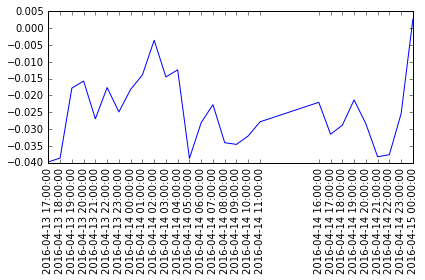

In [28]:
%matplotlib inline
avg_sentiments = sorted(avg_sentiments, key=lambda x: x[0])
plt.plot(zip(*avg_sentiments)[0], zip(*avg_sentiments)[1])
plt.xticks(zip(*avg_sentiments)[0], zip(*avg_sentiments)[0], rotation=90)
plt.tight_layout()
plt.show()